In [1]:
#import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string
from string import digits

In [2]:
np.set_printoptions(threshold=np.inf)
os.chdir('/content/drive/My Drive/DL_Colab/AutoEncoders/Machine Translation/English-Spanish')

**Download the data**

In [ ]:
#!!curl -O http://www.manythings.org/anki/spa-eng.zip
#!!unzip spa-eng.zip

**Load the data**

In [3]:
#Data Path
data_path = "spa.txt"

#Number of samples to train
num_samples = 20000

lines = pd.read_table(data_path, names=['eng','spa',''])

Here we'll be using a subset of data ie only 50000 sentences out of 124547 sentences. For each timestep in Encoder we'll add sequence as word.

In [4]:
lines.head()

,eng,spa,
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [5]:
lines.shape

(124547, 3)

**Text Preprocessing**

In [6]:
def text_preprocess(text):

  #Remove qoutes
  new_text = re.sub("'",'',text) #this will replace words like can't --> cant

  #Lower the cases
  new_text = new_text.lower()
  
  #Remove special characters
  nopunc = set(string.punctuation)
  new_text = [char for char in new_text if char not in nopunc]
  new_text = ''.join(new_text)

  #Remove numbers from the text
  removed_numbers = str.maketrans('','',digits)
  new_text = new_text.translate(removed_numbers)

  #Remove extra space
  new_text = new_text.strip()
  new_text = re.sub(' +',' ',new_text)

  return new_text



In [7]:
lines['eng'] = lines['eng'].apply(text_preprocess)
lines['spa'] = lines['spa'].apply(text_preprocess)

In [8]:
#To indicate start of seq in target we'll use "START_ " and for end of the seq we'll use " _END"
lines['spa'] = lines['spa'].apply(lambda x: 'START_ '+ x +' _END')

In [9]:
lines['spa'].sample(10)

86178                     START_ casarse es cosa seria _END
110180    START_ compro cosas que sé que no voy a utiliz...
850                                 START_ ella camina _END
59409                         START_ ¡eh tú ¿qué haces _END
82845          START_ no lo dejes escuchar esta música _END
74880         START_ ¿cuándo empezaste a jugar al golf _END
34072                   START_ soy profesor de japonés _END
9296                              START_ es canadiense _END
99502     START_ ¿qué tan seguro estás de que él es un c...
43245                 START_ koko es una gorila hembra _END
Name: spa, dtype: object

**Data Preparation**

We'll create two sets one for English(input) and another for Spanish(target). To this we'll add all the unique words from 20000 sentences.

In [11]:
line_subset = lines[:num_samples+1]

In [12]:
#Get the all unique english words
eng_words = set()
for word in line_subset['eng']:
  for item in word.split():
    if item not in eng_words:
      eng_words.add(item)

#Get the all unique spanish words
spa_words = set()
for word in line_subset['spa']:
  for item in word.split():
    if item not in spa_words:
      spa_words.add(item)

In [13]:
#Get length of the sentences which has maxm number of words for both the language
max_eng_length = max([len(txt) for txt in line_subset['eng'].apply(lambda x: x.split(' '))])
max_spa_length = max([len(txt) for txt in line_subset['spa'].apply(lambda x: x.split(' '))])
print(max_eng_length)
print(max_spa_length)

6
14


In [14]:
#Sort the input and target words and convert it to a list
input_words = sorted(list(eng_words))
target_words = sorted(list(spa_words))
num_encoder_tokens = len(eng_words)
num_decoder_tokens = len(spa_words)
print("Number of unique words in input(English):- ",num_encoder_tokens)
print("Number of unique words in target(Spanish):- ",num_decoder_tokens)

Number of unique words in input(English):-  3731
Number of unique words in target(Spanish):-  7806


In [15]:
#For zero padding increase the count of decoder-token by 1
num_decoder_tokens += 1
num_decoder_tokens

7807

**Vectorize the input and target words**

In [16]:
#Create a dictionary for input and target words and assign an index position to each words for one hot encoding
input_token_index = dict([(word,i) for i,word in enumerate(input_words)])
target_token_index = dict([(word,i) for i,word in enumerate(target_words)])

In [17]:
#Create 3 Numpy arrays:- encoder_input_data, decoder_input_data, decoder_target_data:
encoder_input_data = np.zeros((len(line_subset['eng']),max_eng_length),dtype='float32')
decoder_input_data = np.zeros((len(line_subset['spa']),max_spa_length),dtype='float32')
decoder_target_data = np.zeros((len(line_subset['spa']),max_spa_length,num_decoder_tokens),dtype='float32')

In [18]:
for i, (input_text,target_text) in enumerate(zip(line_subset['eng'],line_subset['spa'])):
  
  for t, word in enumerate(input_text.split()):
    encoder_input_data[i,t] = input_token_index[word]
  
  for t, word in enumerate(target_text.split()):
    decoder_input_data[i,t] = target_token_index[word]

    if t > 0:
      decoder_target_data[i, t-1, target_token_index[word]] = 1.


**Build the model**

In [19]:
from keras.layers import Input,LSTM,Embedding,Dense
from keras.models import Model

In [20]:
embedding_size = 80

**Encoder Model**

In [21]:
encoder_inputs = Input(shape=(None,))
encoder_embed = Embedding(num_encoder_tokens,embedding_size)(encoder_inputs)
encoder_lstm = LSTM(embedding_size,return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embed)
encoder_states = [state_h,state_c]

**Decoder Model**

In [22]:
decoder_inputs = Input(shape=(None,))
decoder_embed_layer = Embedding(num_decoder_tokens,embedding_size)
decoder_embed = decoder_embed_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(units=embedding_size,return_sequences=True,return_state=True)
decoder_outputs,_,_ = decoder_lstm(decoder_embed,initial_state = encoder_states)
decoder_dense = Dense(num_decoder_tokens,activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [23]:
#Define the model and compile
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 80)     298480      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 80)     624560      input_2[0][0]                    
_______________________________________________________________________________________

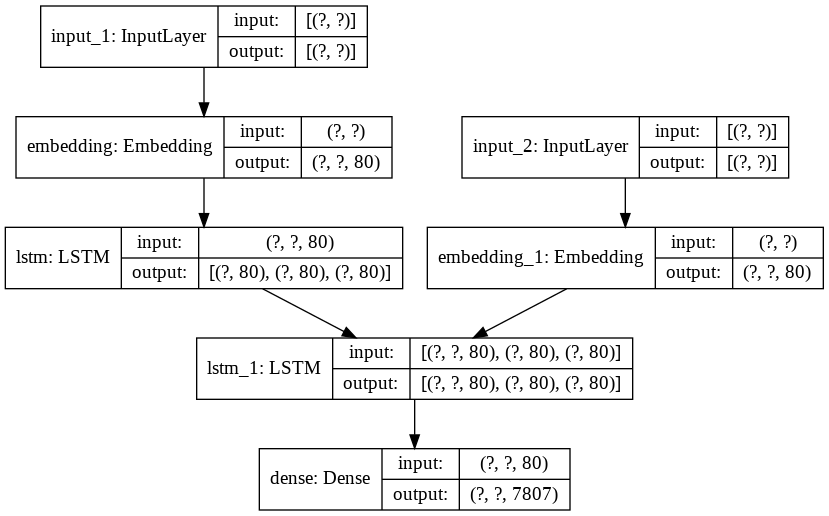

In [24]:
#Plot the model
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes = True)

**Train the model**

In [25]:
batch_size = 128
epochs = 100

In [26]:
model.fit([encoder_input_data,decoder_input_data],decoder_target_data,batch_size=batch_size,epochs=epochs,validation_split=0.1)

**Save the weights**

In [27]:
model.save_weights('eng_spa_weights.h5')


**Inference Model**

In [28]:
encoder_model = Model([encoder_inputs,encoder_states])

decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_state_inputs = [decoder_state_input_h,decoder_state_input_c]

# Get the embeddings of the decoder sequence
decoder_embed2 = decoder_embed_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embed2,initial_state=decoder_state_inputs)
decoder_states2 = [state_h2,state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs]+decoder_state_inputs, [decoder_outputs2]+decoder_states2)

In [29]:
#Reverse-lookup token index to turn sequences back to words
reverse_input_token_index = dict((i,char) for char, i in input_token_index.items())
reverse_target_token_index = dict((i,char) for char, i in target_token_index.items())

**Define a function that decodes some sequence in English to output Spanish text**

In [30]:
def decode_sequence(input_seq):

  encoder_model = Model(encoder_inputs,encoder_states)

  #Encode the input as state vectors
  states_value = encoder_model.predict(input_seq)

  #Generate empty target sequence of length 1 with only the start character
  target_seq = np.zeros((1,1))
  target_seq[0,0] = target_token_index['START_']

  #Create a output sequence loop untill we recieve a stop sign
  stop_condition = False
  decoded_sentence = ""

  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token and add the corresponding character to the decoded sequence
    # argmax: Returns the indices of the maximum values along an axis
    # just like find the most possible char

    # Get the predicted token (the token with the highest score)
    sampled_token_index = np.argmax(output_tokens[0, -1, :])

    # Get the character belonging to the token
    sampled_char = reverse_target_token_index[sampled_token_index]

    # Append char to decoded sequence
    decoded_sentence += ' '+sampled_char

    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_char == '_END') or len(decoded_sentence) > max_spa_length:
      stop_condition = True

    #Update the target sequence
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index

    #Update the state vectors
    states_value = [h, c]
  
  return decoded_sentence

In [ ]:
 #Let's sample a few test cases!

 for seq_index in [1,9987,5423,19876,7655,8453,17865,9066,4533,14098,12212,10098,2234,7543,12345,1234,123]:
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', line_subset['eng'][seq_index: seq_index + 1])
    print('Actual target sentence:', lines['spa'][seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: 1    go
Name: eng, dtype: object
Actual target sentence: 1    START_ vete _END
Name: spa, dtype: object
Decoded sentence:  ve _END
-
Input sentence: 9987    were going out
Name: eng, dtype: object
Actual target sentence: 9987    START_ vamos a salir _END
Name: spa, dtype: object
Decoded sentence:  nosotros salimos
-
Input sentence: 5423    this is wrong
Name: eng, dtype: object
Actual target sentence: 5423    START_ es incorrecto _END
Name: spa, dtype: object
Decoded sentence:  está demasiado
-
Input sentence: 19876    you cant use that
Name: eng, dtype: object
Actual target sentence: 19876    START_ no puedes usarlo _END
Name: spa, dtype: object
Decoded sentence:  no puedes decir
-
Input sentence: 7655    where are they
Name: eng, dtype: object
Actual target sentence: 7655    START_ ¿dónde están _END
Name: spa, dtype: object
Decoded sentence:  ¿dónde están _END
-
Input sentence: 8453    i have no money
Name: eng, dtype: object
Actual target sentence: 8453    START_ n